# 이변량 분석 종합실습2 : Mobile 고객 이탈 분석

* 여러분은 OO 통신화사 데이터분석가 입니다.
* 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 데이터분석을 의뢰하였습니다.
* 고객 이탈여부(CHURN)에 영향을 주는 요인을 찾아 봅시다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

### 1) 라이브러리 로딩

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

### 2) 데이터 로딩

In [6]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
mobile = pd.read_csv(data_path)
mobile.drop(['id', 'REPORTED_USAGE_LEVEL','OVER_15MINS_CALLS_PER_MONTH'], axis = 1, inplace = True)
mobile.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,47711,183,17,730589.0,192,5,unsat,considering,0
1,0,74132,191,43,535092.0,349,2,unsat,no,1
2,1,150419,0,14,204004.0,682,6,unsat,considering,0
3,0,159567,0,58,281969.0,634,1,very_unsat,never_thought,0
4,1,23392,0,0,216707.0,233,15,unsat,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


In [7]:
mobile.isna().sum()

COLLEGE                         0
INCOME                          0
OVERAGE                         0
LEFTOVER                        0
HOUSE                         215
HANDSET_PRICE                   0
AVERAGE_CALL_DURATION           0
REPORTED_SATISFACTION          38
CONSIDERING_CHANGE_OF_PLAN      0
CHURN                           0
dtype: int64

In [8]:
# 18000개 이므로 215 , 38 버리자
mobile.shape

(18000, 10)

----

## 1.이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)를 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 유의수준 : 5%
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.

In [18]:
target = 'CHURN'

In [19]:
# 전체 이탈율
total_mean = mobile[target].mean()
print(total_mean)

tmp_mean = tmp[target].mean()
print(tmp_mean)

0.49272222222222223
0.49309742491688735


In [20]:
mobile.isna().sum()

COLLEGE                         0
INCOME                          0
OVERAGE                         0
LEFTOVER                        0
HOUSE                         215
HANDSET_PRICE                   0
AVERAGE_CALL_DURATION           0
REPORTED_SATISFACTION          38
CONSIDERING_CHANGE_OF_PLAN      0
CHURN                           0
dtype: int64

### (1) 범주형 Feature --> CHURN
* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 교차표(pd.crosstab())  
    ② 시각화( Stacked Bar, Mosaic)  
    ③ 가설검정(카이제곱검정)
* 각 feature 별로 관계의 정도를 3가지로 정리해봅시다. 

#### 1) COLLEGE --> CHURN

In [136]:
var = 'COLLEGE'

① 교차표(pd.crosstab())

In [137]:
temp = pd.crosstab(mobile[var], mobile[target] , normalize = 'index')
temp

CHURN,0,1
COLLEGE,,
0,0.515697,0.484303
1,0.498950,0.501050


② 시각화( Stacked Bar, Mosaic)

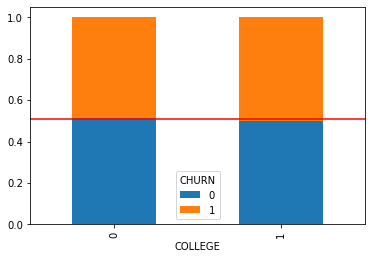

In [138]:
# 100% Stacked Bar
temp.plot.bar(stacked=True)
plt.axhline(1-total_mean, color = 'r')
plt.show()

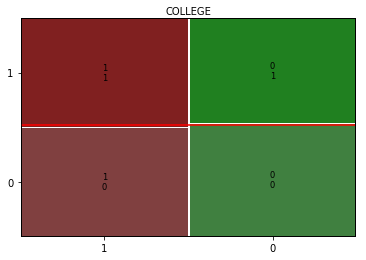

In [139]:
# Mosaic
mosaic(mobile, [ var, target]) # [x축, y축]
plt.axhline(1- total_mean, color = 'r')
plt.xlabel(var)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

> COLLEGE와 CHURN 간에는 관련이 없어 보임

③ 가설검정(카이제곱검정)

In [140]:
table = pd.crosstab(mobile[target], mobile[var])  #카이제곱때 normalize 하지않기
chiresult = spst.chi2_contingency(table) 
print("카이제곱통계량 : {}".format(chiresult[0]))
print("p-value : {:.20f}".format(chiresult[1]))

카이제곱통계량 : 4.982102934693503
p-value : 0.02561083347822053560


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

> * 차트를 통해서는 대학졸업여부와 이탈여부는 관련이 없어 보임. 
* 그러나 카이제곱검정으로는 pvalue가 0.02로 유의수준 0.05보다 작게 나옴
* 결론 : 아주약한 관계

#### 2) REPORTED_SATISFACTION  --> CHURN

In [141]:
var = 'REPORTED_SATISFACTION'

① 교차표(pd.crosstab())

In [142]:
temp = pd.crosstab(mobile[var], mobile[target] , normalize = 'index')
temp

CHURN,0,1
REPORTED_SATISFACTION,,
avg,0.527132,0.472868
sat,0.527897,0.472103
unsat,0.499164,0.500836
very_sat,0.511618,0.488382
very_unsat,0.500990,0.499010


② 시각화( Stacked Bar, Mosaic)

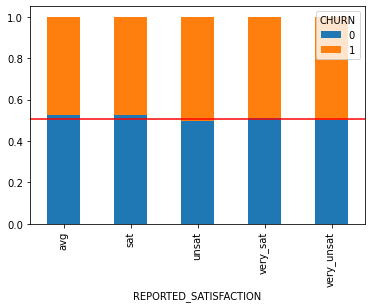

In [143]:
# 100% Stacked Bar
temp.plot.bar(stacked=True)
plt.axhline(1-total_mean, color = 'r')
plt.show()

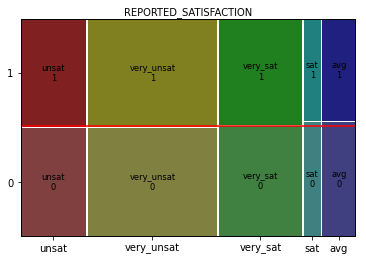

In [144]:
# Mosaic
mosaic(mobile, [ var, target]) # [x축, y축]
plt.axhline(1- total_mean, color = 'r')
plt.xlabel(var)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

③ 가설검정(카이제곱검정)

In [145]:
table = pd.crosstab(mobile[target], mobile[var])  #카이제곱때 normalize 하지않기
chiresult = spst.chi2_contingency(table) 
print("카이제곱통계량 : {}".format(chiresult[0]))
print("p-value : {:.20f}".format(chiresult[1]))

카이제곱통계량 : 6.8411009572056445
p-value : 0.14452738878905066477


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

#### 3) CONSIDERING_CHANGE_OF_PLAN --> CHURN

In [146]:
var = 'CONSIDERING_CHANGE_OF_PLAN'

① 교차표(pd.crosstab())

In [147]:
temp = pd.crosstab(mobile[var], mobile[target] , normalize = 'index')
temp

CHURN,0,1
CONSIDERING_CHANGE_OF_PLAN,,
actively_looking_into_it,0.511565,0.488435
considering,0.510853,0.489147
never_thought,0.513304,0.486696
no,0.500274,0.499726
perhaps,0.475992,0.524008


② 시각화( Stacked Bar, Mosaic)

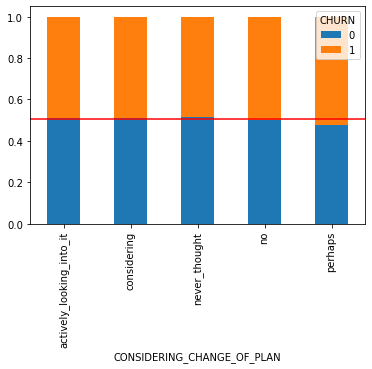

In [148]:
# 100% Stacked Bar
temp.plot.bar(stacked=True)
plt.axhline(1-total_mean, color = 'r')
plt.show()

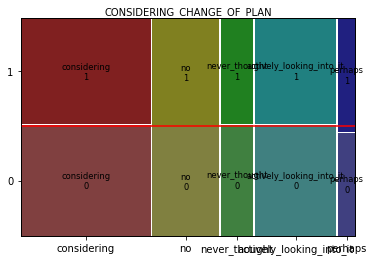

In [149]:
# Mosaic
mosaic(mobile, [ var, target]) # [x축, y축]
plt.axhline(1- total_mean, color = 'r')
plt.xlabel(var)
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

- perhaps 범주만 약간 차이있음

③ 가설검정(카이제곱검정)

In [150]:
table = pd.crosstab(mobile[target], mobile[var])  #카이제곱때 normalize 하지않기
chiresult = spst.chi2_contingency(table) 
print("카이제곱통계량 : {}".format(chiresult[0]))
print("p-value : {:.20f}".format(chiresult[1]))

카이제곱통계량 : 5.421434419620689
p-value : 0.24672225866799690763


④ 시각화와 가설검정을 통해서 파악한 내용을 적어 봅시다.

- CONSIDERING_CHANGE_OF_PLAN 는 자유도4로 카이제곱통계량 5.4는 차이가 크지않다고볼수잇따. pvalue 도
의미없어보임

### (2) 숫자형 Feature --> CHURN

* 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  
    ① 그래프 : histogram, densityplot   
    ② 수치화 : 로지스틱회귀

#### 1) INCOME --> CHURN


In [151]:
var = 'INCOME'

① 그래프 : histogram, densityplot

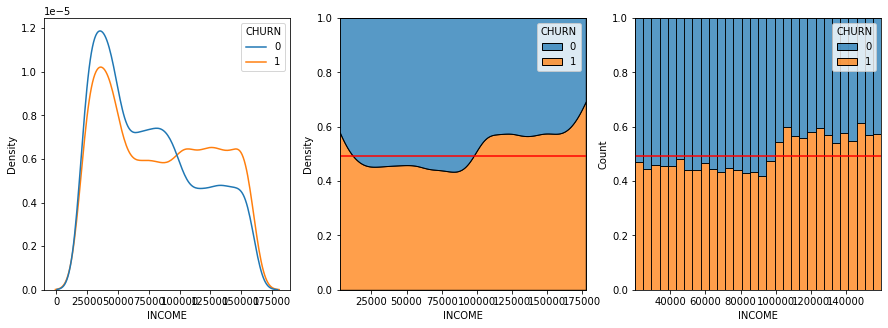

In [152]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(1,3,2)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(1,3,3)
sns.histplot(x=var, data = mobile, bins = 30
             , hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')
plt.show()

시각화를 통해 파악한 내용을 적어 봅시다.

> * 100000 달러를 기준으로 나뉨.
    * 100000 이내 : 잔류가 더 높음
    * 100000 이상 : 이탈이 더 높음.
* 왜???

② 수치화 : 로지스틱회귀

In [153]:
model=sm.Logit(mobile[target], mobile[var])
result=model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692683
         Iterations 2
INCOME    0.000044
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

> * 그래프상으로 10만달러 기준으로 이탈율에 차이가 있다.
* 로지스틱회귀로 부터 얻은 P-value가 0.000044로 0.05보다 작으므로 관련이 있다.
* 결론: **강한 관계**가 있다.

#### 2) OVERAGE --> CHURN


In [154]:
var = 'OVERAGE'

① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

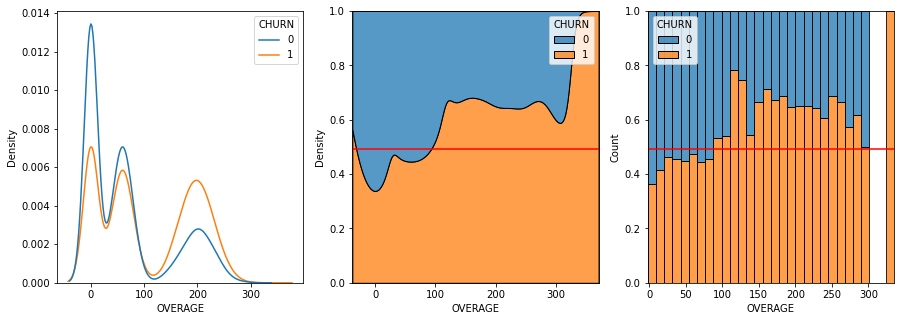

In [155]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(1,3,2)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(1,3,3)
sns.histplot(x=var, data = mobile, bins = 30
             , hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')
plt.show()

② 수치화 : 로지스틱회귀

In [156]:
model=sm.Logit(mobile[target], mobile[var])
result=model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.680553
         Iterations 4
OVERAGE    3.521095e-97
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

- 월 사용량이 미달인분들은 본인이 사용하는 요금제에있어 딱히 불만이없어서라고 생각이된다. 따라서 만족도와 상관관계도 알아보면좋을거같다.
- 반면에 90분이상 오버해서 사용하는사람들은 불만을느끼고 있어서 이탈율이 높은것으로 생각이된다.
- p-value 가 매우낮아 강한 상관성을 보여준다.

#### 3) LEFTOVER --> CHURN


In [157]:
var = 'LEFTOVER'

① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

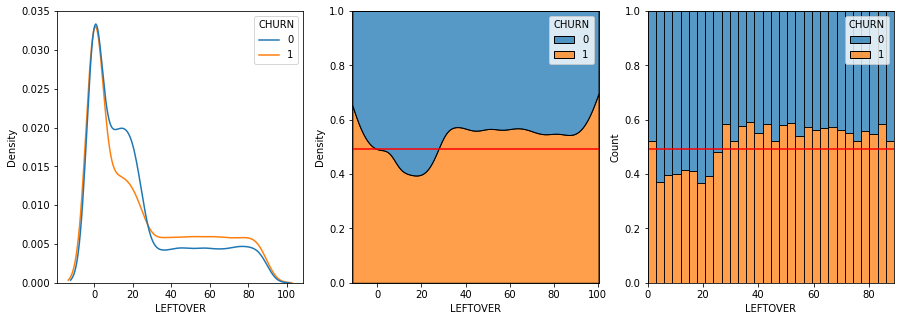

In [158]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(1,3,2)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(1,3,3)
sns.histplot(x=var, data = mobile, bins = 30
             , hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')
plt.show()

② 수치화 : 로지스틱회귀

In [159]:
model=sm.Logit(mobile[target], mobile[var])
result=model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692532
         Iterations 3
LEFTOVER    0.000003
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

- 매달 잔여시간을 30분보다 넘게 남기는사람들의 이탈율이 비교적 높게 나왔다. p-value도 타당한 수치이다 
- 잔여 시간이 30분정도 모자라는것은 간편한 쿠폰등을 발급 받을수 있게 해보자

#### 4) HOUSE --> CHURN


* **[주의]** HOUSE에 NaN이 존재합니다. ==> 로지스틱회귀를 수행하기 위해서는 NaN을 제외한 데이터로 수행해야 합니다.

In [3]:
var = 'HOUSE'

① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

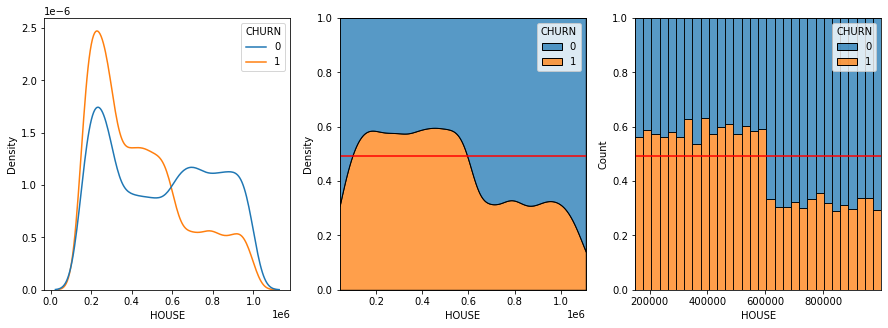

In [10]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(1,3,2)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(1,3,3)
sns.histplot(x=var, data = mobile, bins = 30
             , hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')
plt.show()

In [11]:
tmp = mobile.dropna(axis=0)
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17747 entries, 0 to 17784
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   COLLEGE                     17747 non-null  int64  
 1   INCOME                      17747 non-null  int64  
 2   OVERAGE                     17747 non-null  int64  
 3   LEFTOVER                    17747 non-null  int64  
 4   HOUSE                       17747 non-null  float64
 5   HANDSET_PRICE               17747 non-null  int64  
 6   AVERAGE_CALL_DURATION       17747 non-null  int64  
 7   REPORTED_SATISFACTION       17747 non-null  object 
 8   CONSIDERING_CHANGE_OF_PLAN  17747 non-null  object 
 9   CHURN                       17747 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 1.5+ MB


② 수치화 : 로지스틱회귀

In [12]:
model=sm.Logit(tmp[target], tmp[var])
result=model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.687256
         Iterations 2
HOUSE    6.686896e-47
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

#### 5) HANDSET_PRICE --> CHURN


In [13]:
var = 'HANDSET_PRICE'

① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

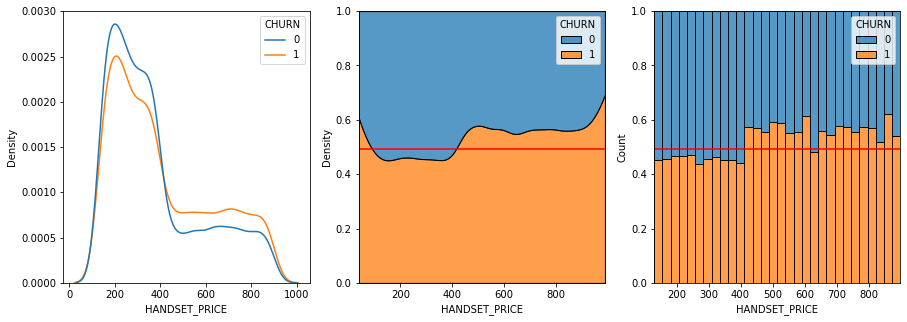

In [14]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(1,3,2)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(1,3,3)
sns.histplot(x=var, data = mobile, bins = 30
             , hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')
plt.show()

- 가격이 400 달러 기준으로 나뉨 * 이내: 이탈율 낮음 * 이상:이탈율 높음

② 수치화 : 로지스틱회귀

In [16]:
model=sm.Logit(mobile[target], mobile[var])
result=model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692730
         Iterations 3
HANDSET_PRICE    0.000107
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

#### 6) AVERAGE_CALL_DURATION --> CHURN


In [167]:
var = 'AVERAGE_CALL_DURATION'

① 그래프 : histogram, densityplot

시각화를 통해 파악한 내용을 적어 봅시다.

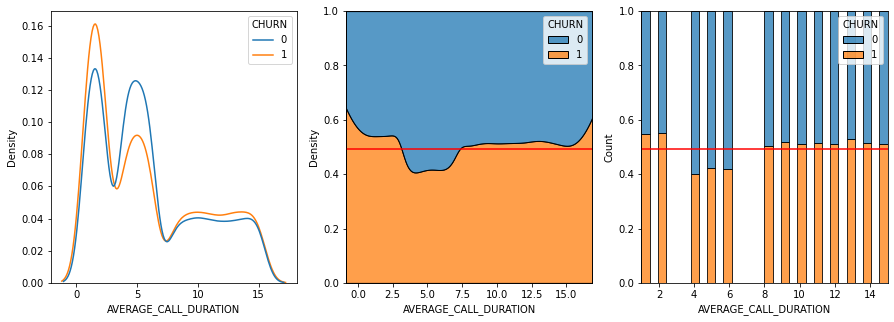

In [169]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.kdeplot(x=var, data = mobile, hue =target, common_norm = False)

plt.subplot(1,3,2)
sns.kdeplot(x=var, data = mobile, hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')

plt.subplot(1,3,3)
sns.histplot(x=var, data = mobile, bins = 30
             , hue =target, multiple = 'fill')
plt.axhline(mobile[target].mean(), color = 'r')
plt.show()

② 수치화 : 로지스틱회귀

In [15]:
model=sm.Logit(tmp[target], tmp[var])
result=model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.692695
         Iterations 3
HANDSET_PRICE    0.000063
dtype: float64


③ 시각화와 수치화를 통해 파악한 내용을 적어 봅시다.

- 평균시간 3분이내 이탈율 높음 3~7낮음 7분이상 약간높음

## 2.관계 정리

### 1) 강한관계의 변수

In [ ]:
income
overge
leftover
house

### 2) 약한관계의 변수

In [ ]:
college
handset_price
average_call_duration

### 3) 관계 없음

In [ ]:
reported_satisfaction
considering_change_of_plan

### 4) 추가 분석